导入必要工具包

In [2]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

导入数据

In [50]:
path = 'Desktop/RentListingInquries/code/data/'
test = pd.read_csv(path+'RentListingInquries_FE_test.csv')
train = pd.read_csv(path+'RentListingInquries_FE_train.csv')
train.head()

,bathrooms,bedrooms,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,Month,Day,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
0,1.5,3,3000,1200.0,750.000000,-1.5,4.5,2016,6,24,...,0,0,0,0,0,0,0,0,0,1
1,1.0,2,5465,2732.5,1821.666667,-1.0,3.0,2016,6,12,...,0,0,0,0,0,0,0,0,0,2
2,1.0,1,2850,1425.0,1425.000000,0.0,2.0,2016,4,17,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,3275,1637.5,1637.500000,0.0,2.0,2016,4,18,...,0,0,0,0,0,0,0,0,0,2
4,1.0,4,3350,1675.0,670.000000,-3.0,5.0,2016,4,28,...,0,0,1,0,0,0,0,0,0,2


分离训练数据的x和y

In [51]:
y_train = train['interest_level']
x_train = train.drop('interest_level',axis=1)

构造一个寻找最佳n_estimators的函数

In [55]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
def modelfit(alg, X_train, y_train, cv_folds=None, early_stopping_rounds=10):
    xgb_param = alg.get_xgb_params()
    xgb_param['num_class'] = 3       #因为是三类分类问题
    
    xgtrain = xgb.DMatrix(X_train, label = y_train)
        
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =cv_folds,
             metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
    #直接采用xgb的cv函数
    
    cvresult.to_csv('1_nestimators.csv', index_label = 'n_estimators')
    n_estimators = cvresult.shape[0]
    alg.set_params(n_estimators = n_estimators)
    alg.fit(X_train, y_train, eval_metric='mlogloss')

In [57]:
#除n_estimators外的其他参数暂时不变
xgb1 = XGBClassifier(
        learning_rate = 0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma = 0,
        objective='multi:softprob',
        seed=3
)
modelfit(xgb1,x_train,y_train,cv_folds=kfold)
cvresult = pd.DataFrame.from_csv("1_nestimators.csv")#将结果保存到csv文件里

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  # This is added back by InteractiveShellApp.init_path()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


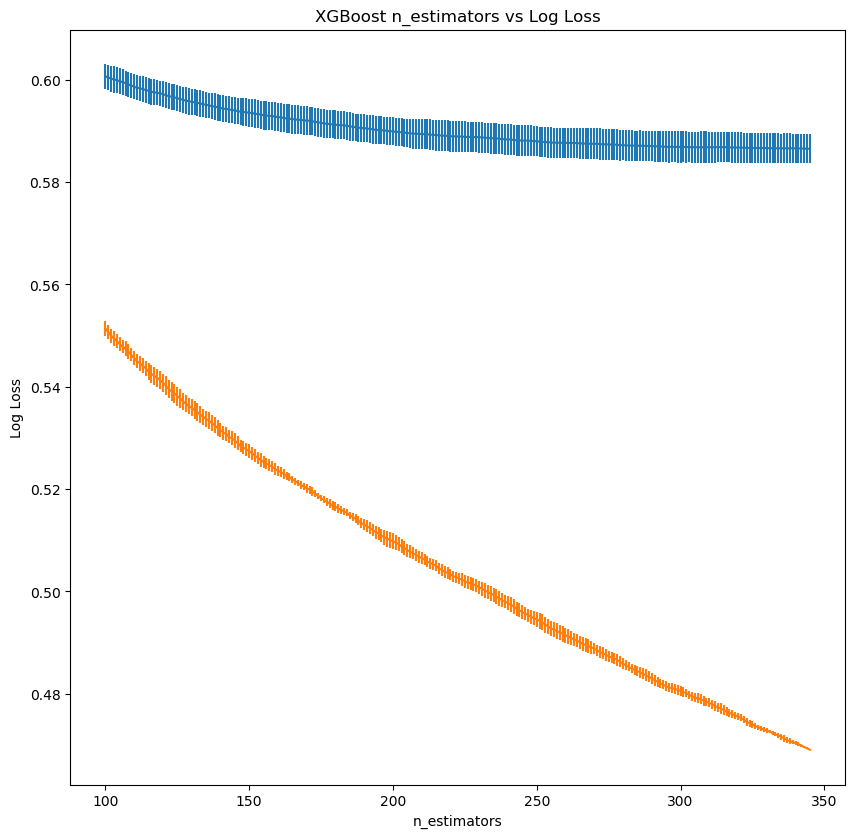

In [58]:
#将n_estimators结果可视化
cvresult = pd.DataFrame.from_csv('1_nestimators.csv')

cvresult = cvresult.iloc[100:]
# plot
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(100,cvresult.shape[0]+100)
        
fig = pyplot.figure(figsize=(10, 10), dpi=100)
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'n_estimators_detail.png' )

pyplot.show()

In [3]:
nestimators = pd.read_csv('Desktop/1_nestimators.csv')
nestimators

,n_estimators,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
0,0,1.957133,0.000806,1.955564,0.001335
1,1,1.785371,0.000738,1.782810,0.001322
2,2,1.649457,0.000877,1.645860,0.001608
3,3,1.537327,0.000630,1.532956,0.001598
4,4,1.443652,0.000704,1.438471,0.001036
5,5,1.363638,0.000796,1.357667,0.001235
6,6,1.294293,0.001085,1.287640,0.001137
7,7,1.232981,0.001594,1.225572,0.001375
8,8,1.179006,0.001369,1.170946,0.001241
9,9,1.131588,0.001206,1.122793,0.001086


可以看到，最佳的n_estimators参数是261